# Notebook to serve as baseline to re-write shearAzimuthalAverager
## build on : data_and_model_demo_DC2

### created by Mijin, Lucie & Marina
################################################################

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import GCRCatalogs
from clmm import ShearAzimuthalAverager

### Read in the data (here cosmoDC2)

In [2]:
extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [3]:
# get a massive halo at intermediate redshift
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 5e14','is_central==True','redshift<0.4'])

mass_list = massive_halos['halo_mass']
select = (mass_list == np.max(mass_list))
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
mass_cl = mass_list[select][0]
print("mass = ", mass_cl/1e14,"*1e14 Msol", "\n ra = ", ra_cl, "\n dec = ", dec_cl,"\n z = ", z_cl)

# make a dictionary for cluster
cl_dict = {'z':z_cl, 'ra':ra_cl, 'dec': dec_cl}


mass =  12.391444739836395 *1e14 Msol 
 ra =  63.28980748965139 
 dec =  -39.647126899140524 
 z =  0.18532355457931704


In [16]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
                ]

z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

# store the results into an astropy table
dat = Table([gal_cat['galaxy_id'],gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['convergence']], \
          names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))

print ("number of galaxies selected = ", len(dat))

number of galaxies selected =  448646


# NEW PIECE OF CODE #################################################################

## Prepare your data

In [34]:
#data_type = "simu" or data_type = "real"
data_type = "simu"

#define cosmo
cosmo = extragalactic_cat.cosmology

if data_type == "simu":
    g1 = dat['gamma1'] / (1 - dat['kappa'])
    g2 = dat['gamma2'] / (1 - dat['kappa'])

## Computes the tangential and cross shear profiles

In [127]:
def compute_shear(ra_l,dec_l,ra_s, dec_s, g1, g2):
    
    """Computes the tangential and cross shear and radius in Mpc for each source in the catalog as:
            g_t = - (g_1 * \cos(2\phi) + g_2 * \sin(2\phi))
            g_c = - g_1 * \sin(2\phi) + g_2 * \cos(2\phi)
            Note: ra_s, dec_s, e1, e2 come from galaxy table, ra_l, dec_l is the cluster center
    """  
    
    coord_l = SkyCoord(ra_l*u.deg,dec_l*u.deg)
    coord_s = SkyCoord(ra_s*u.deg,dec_s*u.deg)
    theta = coord_l.separation(coord_s).to(u.rad).value # in radian

   # cos_phi = (ra_l - ra_s) / theta
   # sin_phi = (dec_l - dec_s) / theta

   # cos2_phi = cos_phi**2 - sin_phi**2 
   # sin2_phi = 2. * sin_phi * cos_phi
 
   # g_t = - (g1 * cos2_phi + g2 * sin2_phi)
   # g_x = - g2 * sin2_phi + g2 * cos2_phi 
    
      
    phi = np.arctan2(dec_s-dec_l, -(ra_s-ra_l))
    g_t = - g1 * np.cos(2.0 * phi) - g2 * np.sin(2.0 * phi)
    g_x = - g1 * np.sin(2.0 * phi) + g2 * np.cos(2.0 * phi)

    return theta, g_t, g_x


In [128]:
theta, g_t , g_x = compute_shear(ra_cl, dec_cl, dat['ra'], dat['dec'], g1, g2)

In [129]:
def make_shear_profile(theta, g, z_l, cosmo, bins = None): #wishlist : add bin_units
    
    """ returns astropy table containing shear profile, g can be g_c or g_t
    Is_binned: boolean
    bins: user defined array of bins

    We want to be able to define units of bins
    """
    
    rMpc = theta * cosmo.angular_diameter_distance(z_l).value
    
    if bins == None:
        nbins = 10
        bins = np.linspace(np.min(rMpc),np.max(rMpc), nbins)

    g_profile = np.zeros(len(bins) - 1)
    gerr_profile = np.zeros(len(bins) - 1)
    rMpc_profile =  np.zeros(len(bins) - 1)

    
    for i in range(len(bins)-1):
        cond = (rMpc >= bins[i]) & (rMpc < bins[i+1])
        index = np.where(cond)[0]
        g_profile[i] = np.average(g[index])
        gerr_profile[i] = np.std(g[index]) / np.sqrt(float(len(index)))
        rMpc_profile[i] = np.average(rMpc[index])

    return rMpc_profile, g_profile, gerr_profile


In [130]:
r, gt, gterr = make_shear_profile(theta, g_t, z_cl, cosmo)
r, gx, gxerr = make_shear_profile(theta, g_x, z_cl, cosmo)

<ErrorbarContainer object of 3 artists>

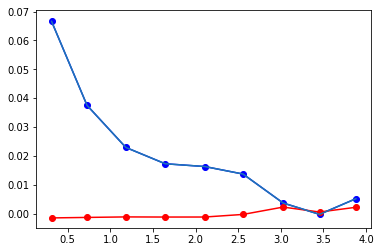

In [131]:
plt.plot(r,gt,'bo-')
plt.plot(r,-gx,'ro-')
plt.errorbar(r,gt,gterr)

<ErrorbarContainer object of 3 artists>

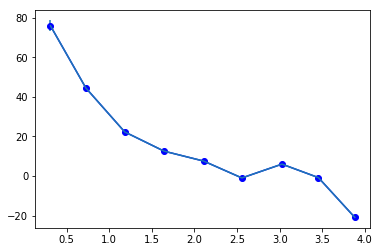

In [120]:
plt.plot(r,g,'bo-')
plt.errorbar(r,g,gerr)